<!-- ---
title: "Week 6"
title-block-banner: true
title-block-style: default
execute:
  freeze: true
  cache: true
format: html
# format: pdf
--- -->

In [2]:
dir <- "~/work/courses/stat380/weeks/week-8/"
setwd(dir)
library(renv)
renv::activate(dir)



## Agenda:

1. Logistic regression
1. Logistic regression with torch
1. Classification using Neural Netoworks

#### Packages we will require this week

In [5]:
packages <- c(
    # Old packages
    "ISLR2",
    "dplyr",
    "tidyr",
    "readr",
    "purrr",
    "glmnet",
    "caret",
    "repr",
    # NEW
    "torch",
    "mlbench"
)

# renv::install(packages)
sapply(packages, require, character.only=TRUE)

Loading required package: ISLR2

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr

Loading required package: readr

Loading required package: purrr


Attaching package: ‘purrr’


The following object is masked from ‘package:renv’:

    modify


Loading required package: glmnet

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-6

Loading required package: caret

Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: repr

Loading required package: torch

Loading required package: mlbench



ISLR2   dplyr   tidyr   readr   purrr  glmnet   caret    repr   torch mlbench 
   TRUE    TRUE    TRUE    TRUE    TRUE    TRUE    TRUE    TRUE    TRUE    TRUE

$$
\boxed{y = \beta_0 + \beta_1 x_1 + \dots \beta_p x_p}
$$

looking at different loss functions:

1. Least-squares: 
$$
L(\beta) = \sum_{i=1}^n \| y_i - \beta_0 - \beta_1 x_1 - \dots - \beta_p x_p\|^2
$$

2. Penalized least squares/LASSO:

$$
L(\beta) = \sum_{i=1}^n \| y_i - \beta_0 - \beta_1 x_1 - \dots - \beta_p x_p\|^2 + \lambda \|{\beta}\|_1
$$

# Classification

We will be using the following dataset for the examples here

> Breast cancer dataset: This dataset contains measurements of various characteristics of breast cancer cells, with the goal of predicting whether a tumor is benign or malignant.

In [6]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
col_names <- c("id", "diagnosis", paste0("feat", 1:30))
df <- read_csv(
    url, col_names, col_types = cols()
    ) %>% 
    select(-id) %>% 
    mutate(outcome = ifelse(diagnosis == "M", 1, 0)) %>%
    select(-diagnosis)

In [7]:
head(df)

feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,⋯,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,⋯,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,⋯,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,⋯,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,⋯,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,⋯,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1
12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,⋯,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,1


The problem with linear regression for binary responses

Let's start by looking at an example. Imagine we have a dataset with a binary response variable (0 or 1) and a continuous predictor variable. We might be tempted to use linear regression with the lm() function to model the relationship between the predictor and response variables. After all, linear regression is a powerful and flexible tool that can be used to model a wide range of relationships between variables.

However, when we use linear regression with a binary response variable, we quickly run into a problem. The linear regression model will give us a predicted value for the response variable for any given value of the predictor variable, but this predicted value is not a probability. The predicted value can take on any value between 0 and 1, but it doesn't necessarily represent the probability of the response variable being a 1.

To see why this is a problem, consider the following scenario. Suppose we have a dataset with a binary response variable and a continuous predictor variable. We fit a linear regression model to the data using the lm() function in R, and we get a predicted value of 0.8 for the response variable when the predictor variable has a value of 1.5. What does this predicted value of 0.8 actually mean?

If we interpret the predicted value as a probability, we might conclude that the probability of the response variable being a 1 when the predictor variable has a value of 1.5 is 0.8. But this interpretation is incorrect. The predicted value from linear regression is not a probability, and it can take on values greater than 1 or less than 0.

In [8]:
reg_model <- lm(outcome ~ ., df)
summary(reg_model)


Call:
lm(formula = outcome ~ ., data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.60241 -0.16209 -0.02705  0.12982  0.82295 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.0218117  0.4280072  -4.724 2.96e-06 ***
feat1       -0.2177721  0.1735089  -1.255 0.209985    
feat2        0.0045455  0.0079439   0.572 0.567426    
feat3        0.0237399  0.0250985   0.946 0.344641    
feat4        0.0003178  0.0005253   0.605 0.545391    
feat5        0.0846891  2.0172759   0.042 0.966529    
feat6       -4.2220353  1.3336803  -3.166 0.001635 ** 
feat7        1.3979973  1.0458611   1.337 0.181887    
feat8        2.1418330  1.9791819   1.082 0.279657    
feat9        0.1027092  0.7427382   0.138 0.890067    
feat10       0.0332616  5.5722693   0.006 0.995240    
feat11       0.4349559  0.3104682   1.401 0.161800    
feat12      -0.0067585  0.0368439  -0.183 0.854525    
feat13      -0.0225203  0.0411183  -0.548 0.584129    
feat14      

In [9]:
n <- 100
new_patients <- data.frame(matrix(rnorm(30 * n), nrow = n))
colnames(new_patients) <- paste0("feat", 1:30)
new_predictions <- predict(reg_model, newdata = new_patients, type = "response")

In [10]:
print(new_predictions %>% head())

          1           2           3           4           5           6 
 -7.5456628 -26.0045484  26.2008222  33.7476344 -34.7416032  -0.5096587 


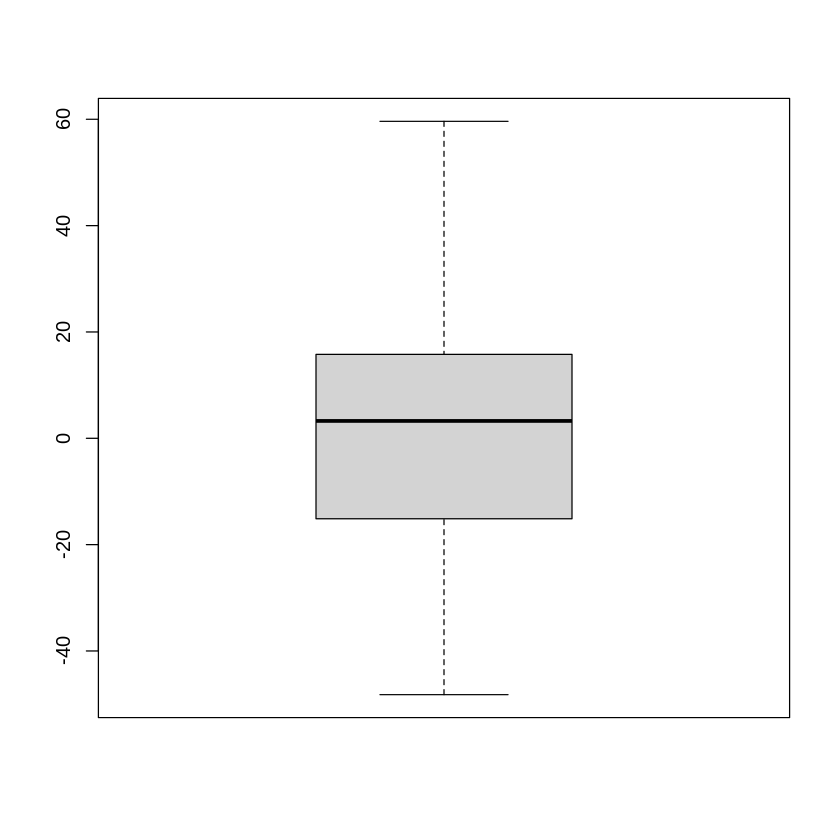

In [11]:
boxplot(new_predictions)

$$
\begin{aligned}
log-odds(p(x)) = b_0 + b_1 x\\ \\ \\ \\
p(x) = \frac{1}{1 + \exp(\beta_0 + \beta_1 x)}
\end{aligned}
$$

## The need for logistic regression

So, what do we do when we have a binary response variable and we want to model the relationship between the predictor and response variables? This is where logistic regression comes in. Logistic regression is a type of generalized linear model that is specifically designed for binary response variables.

The main idea behind logistic regression is to transform the predicted values from linear regression so that they represent probabilities. We do this using a function called the logistic function, which maps any value between negative infinity and positive infinity to a value between 0 and 1. The logistic function is a sigmoidal curve that looks like an elongated S-shape. By applying the logistic function to the predicted values from linear regression, we can transform them into probabilities that represent the probability of the response variable being a 1.

In the next section, we'll dive into the details of logistic regression and see how it works in practice using the breast cancer dataset.


#### Odds and odds ratios

Let's start by defining the odds of an event occurring. The odds of an event occurring are defined as the probability of the event occurring divided by the probability of the event not occurring. For example, if the probability of a basketball team winning a game is 0.6, then the odds of the team winning the game are 0.6/0.4 = 1.5.

Odds ratios are a way to compare the odds of an event occurring between two different groups. The odds ratio is defined as the ratio of the odds of an event occurring in one group to the odds of the event occurring in another group. For example, if the odds of a basketball team winning a game are 1.5 in one group and 2.0 in another group, then the odds ratio of the first group to the second group is 1.5/2.0 = 0.75.

In [12]:
set.seed(123)
binary_var <- rbinom(100, size = 1, prob = 0.6)
group_var <- sample(1:2, size = 100, replace = TRUE)
odds_group1 <- sum(binary_var[group_var == 1]) / sum(!binary_var[group_var == 1])
odds_group2 <- sum(binary_var[group_var == 2]) / sum(!binary_var[group_var == 2])
odds_ratio <- odds_group1 / odds_group2
cat(paste("Odds group 1:", round(odds_group1, 2), "\n"))
cat(paste("Odds group 2:", round(odds_group2, 2), "\n"))
cat(paste("Odds ratio:", round(odds_ratio, 2), "\n"))

Odds group 1: 1.3 
Odds group 2: 1.7 
Odds ratio: 0.76 


#### Logistic regression model

Now let's move on to the logistic regression model. The logistic regression model is a type of generalized linear model that models the probability of an event occurring as a function of one or more predictor variables. The logistic regression model uses the logistic function, also known as the sigmoid function, to model the relationship between the predictor variables and the probability of the event occurring.

**The sigmoid function is given as follows**

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

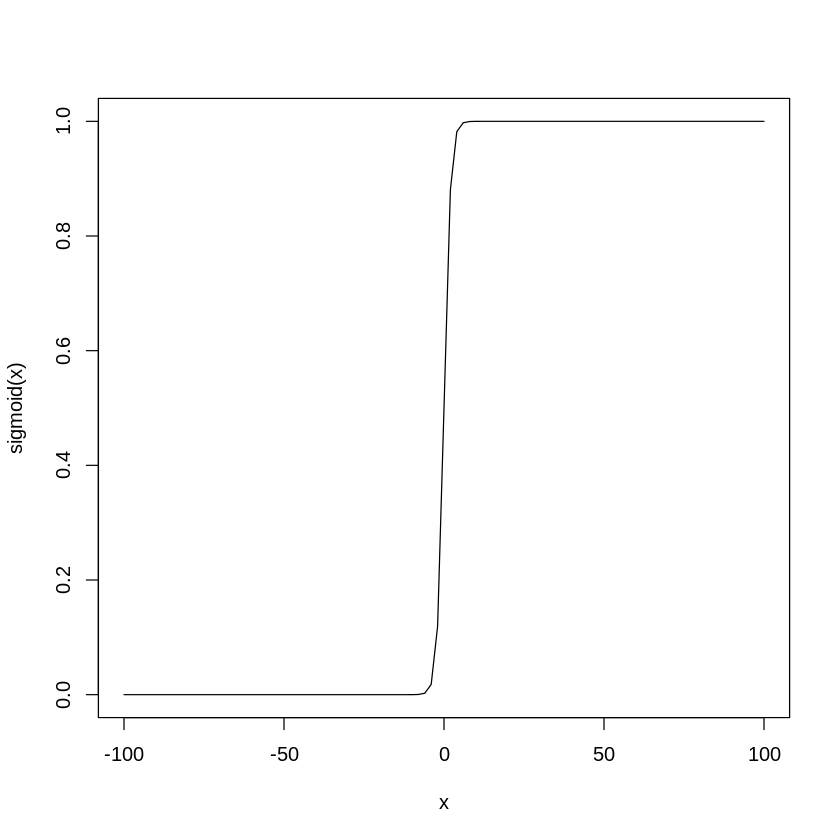

In [13]:
sigmoid <- \(x)  1 / (1 + exp(-x))

curve(sigmoid, -100, 100, ylab="sigmoid(x)")

In logistic regression, the underlying model is assumed to be of the form

$$
\boxed{p(x) = \sigma\Big(\beta_0 + \beta_1 x\Big) = \frac{1}{1 + \exp({-\beta_0 - \beta_1 x})}}
$$

where $p(x)$ where is the probability of the event occurring given the value of the predictor variable $x$, and $b0$ and $b1$ are the **intercept** and **slope** coefficients of the logistic regression model, respectively. 

> $p(x)$ is gauranteed to be a probability for all values of $x$. 

Notice how this is similar to **linear regression** which has 
$$
y(x) = \beta_0 + \beta_1 x
$$

The logistic function has an S-shaped curve and maps any real-valued input to a probability between 0 and 1. As such, the logistic regression model is well-suited for modeling binary response variables, where the goal is to predict the probability of an event occurring (e.g., whether a customer will buy a product or not).m

## Logistic regression example

The `glm()` function fits a generalized linear model, which includes logistic regression as a special case.

In [14]:
set.seed(123)
x <- rnorm(100000)
y <- rbinom(100000, size = 1, prob = exp(0.5 + 0.8*x)/(1 + exp(0.5 + 0.8*x)))

In [39]:
y

[1] 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 1
    [37] 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 0
    [73] 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1
   [109] 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 0
   [145] 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0
   [181] 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1
   [217] 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 0 1
   [253] 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1
   [289] 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1
   [325] 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1
   [361] 0 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0
   [397] 0 1 0 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1
   [433] 1 0 1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1
   [469] 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 1
   [505] 1 1 1 0 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 0 0 1
   [541] 0 0 1 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1
   [577] 1 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0
   [613] 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0
   [649] 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 1
   [685] 1 1 0 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0
   [721] 0 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1
   [757] 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0
   [793] 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 0
   [829] 1 0 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 1 0 1
   [865] 1 1 0 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1
   [901] 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1
   [937] 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0
   [973] 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1
  [1009] 0 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1
  [1045] 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1
  [1081] 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1
  [1117] 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1
  [1153] 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
  [1189] 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1
  [1225] 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
  [1261] 1 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0
  [1297] 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 1
  [1333] 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1
  [1369] 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1
  [1405] 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1
  [1441] 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1
  [1477] 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 0
  [1513] 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1
  [1549] 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 1
  [1585] 0 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1
  [1621] 1 1 1 1 1 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0
  [1657] 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 1 0
  [1693] 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0
  [1729] 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0
  [1765] 1 0 0 1 1 1 1 1 1 0 0 0 1 1

In [40]:
model <- glm(y ~ x, family = binomial())
summary(model)


Call:
glm(formula = y ~ x, family = binomial())

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5019  -1.1362   0.6658   0.9597   2.1705  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 0.487662   0.006964   70.03   <2e-16 ***
x           0.786395   0.007761  101.33   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 134107  on 99999  degrees of freedom
Residual deviance: 121865  on 99998  degrees of freedom
AIC: 121869

Number of Fisher Scoring iterations: 4


In [18]:
x_test <- -5.5
sigmoid(coef(model)[1] + coef(model)[2] * x_test)

(Intercept) 
 0.02778092

In [19]:
predict(model, newdata = data.frame(x=x_test), type="response")

1 
0.02778092

In [20]:
new_x <- seq(-2, 2, by = 0.1)
p1 <- predict(model, data.frame(x=new_x))
p2 <- predict(model, data.frame(x=new_x), type="response")

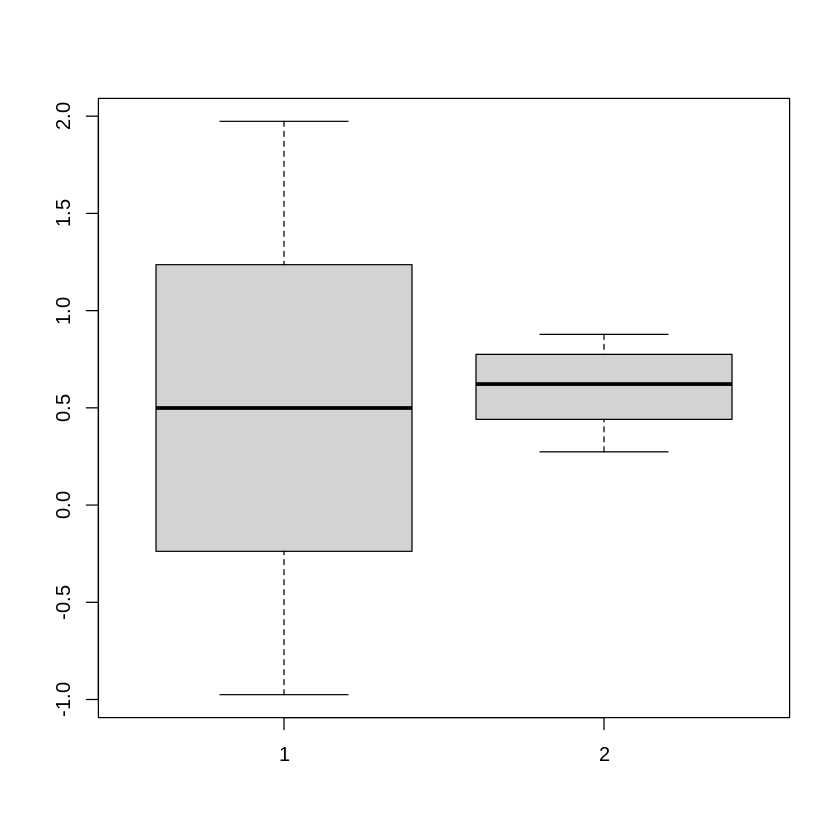

In [21]:
boxplot(p1, p2)

#### Logistic regression for breast cancer


Let's start by fitting a logistic regression model to the breast cancer dataset using the `glm()` function in R. 

In [15]:
df <- df %>% mutate_at("outcome", factor)

In [23]:
model <- glm(outcome ~ ., data = df, family = binomial())
summary(model)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = outcome ~ ., family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -8.49   -8.49   -8.49    8.49    8.49  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.881e+06  2.816e+05 -10.233  < 2e-16 ***
feat1        2.427e+06  2.693e+05   9.014  < 2e-16 ***
feat2        1.958e+05  1.471e+04  13.313  < 2e-16 ***
feat3        1.473e+06  2.464e+04  59.791  < 2e-16 ***
feat4       -1.301e+05  3.907e+03 -33.301  < 2e-16 ***
feat5       -1.525e+08  8.361e+06 -18.234  < 2e-16 ***
feat6       -6.428e+06  3.213e+06  -2.001  0.04540 *  
feat7        1.042e+06  1.408e+06   0.740  0.45959    
feat8       -1.716e+07  5.382e+06  -3.188  0.00143 ** 
feat9        4.049e+07  7.772e+05  52.093  < 2e-16 ***
feat10      -4.233e+07  2.169e+06 -19.519  < 2e-16 ***
feat11       3.328e+07  1.169e+06  28.478  < 2e-16 ***
feat12       6.368e+06  2.005e+05  31.763  < 2e-16 ***
feat13       1.701e+06  4.720e+04  36.032  < 

---

The output of the summary() function provides a summary of the model, including the coefficients of each predictor, their standard errors, and the corresponding p-values. The coefficients represent the log odds ratio of the response variable for each predictor. We can exponentiate the coefficients to get the odds ratios:m

In [24]:
new_patient <- data.frame(matrix(rnorm(30), nrow = 1))
names(new_patient) <- paste0("feat", 1:30)
predict(model, newdata = new_patient, type = "response")

1 
2.220446e-16

# Redo logistic regression, but this time using the `torch` library

Now that we have the torch library installed, we can perform logistic regression using the following steps:

1. Convert the data to a tensor
1. Define the model architecture
1. Define the loss function
1. Define the optimizer
1. Train the model
1. Make predictions

In [16]:
X <- cbind(x)
x_tensor <- torch_tensor(X, dtype = torch_float())
y_tensor <- torch_tensor(y, dtype = torch_float())

In [17]:
module <- nn_module(
  "logistic_regression",
  initialize = function() {
    self$fc1 <- nn_linear(1, 1)
    self$fc2 <- nn_sigmoid()
  },
  forward = function(x) {
    x %>% 
      self$fc1() %>% 
      self$fc2()
  }
)

In [18]:
logistic_reg <- module()

In [19]:
y_pred <- logistic_reg(x_tensor)
y_pred %>% head()

torch_tensor
 0.7939
 0.7485
 0.4237
 0.7017
 0.6920
 0.3942
[ CPUFloatType{6,1} ][ grad_fn = <SliceBackward0> ]

> #### Question: What is an appropriate loss function?

In [20]:
L <- function(x, y, model){
    y_pred <- model(x)
    return (mean((y_pred - y)^2))
}

In [21]:
logistic_reg_1 <- module()
L(x_tensor, y_tensor, logistic_reg)

torch_tensor
0.268933
[ CPUFloatType{} ][ grad_fn = <MeanBackward0> ]

---

##### Optimization

In [23]:
logistic_reg_1$parameters

$fc1.weight
torch_tensor
 0.5403
[ CPUFloatType{1,1} ][ requires_grad = TRUE ]

$fc1.bias
torch_tensor
0.01 *
 3.2867
[ CPUFloatType{1} ][ requires_grad = TRUE ]


In [ ]:
optimizer <- optim_adam(logistic_reg_1$parameters, lr=0.0001)

epochs <- 100
for (i in 1:epochs){
    loss <- L(x_tensor, y_tensor, logistic_reg_1)
    
    optimizer$zero_grad()
    loss$backward()
    optimizer$step()
    
    if (i %% 10 == 0) {
        cat(sprintf("Epoch: %d, Loss: %.4f\n", i, loss$item()))
    }
}

In [ ]:
logistic_reg_1$parameters

---

### Logistic loss function
#### a.k.a. Binary cross entropy `nn_bce()`

In [ ]:
nn_bce_loss()

In [34]:
L2 <- function(x, y, model){
    nn_bce_loss()(model(x), y)
}

logistic_reg_2 <- module()
L2(x_tensor, y_tensor, logistic_reg_2)

torch_tensor
0.756458
[ CPUFloatType{} ][ grad_fn = <BinaryCrossEntropyBackward0> ]

---

##### Optimization

In [65]:
optimizer <- optim_adam(logistic_reg_2$parameters, lr=0.0001)

epochs <- 200
for (i in 1:epochs){
    loss <- L2(x_tensor, y_tensor, logistic_reg_2)
    
    optimizer$zero_grad()
    loss$backward()
    optimizer$step()
    
    if (i %% 1000 == 0) {
        cat(sprintf("Epoch: %d, Loss: %.4f\n", i, loss$item()))
    }
}

Epoch: 1000, Loss: 0.9095
Epoch: 2000, Loss: 0.8590
Epoch: 3000, Loss: 0.8136
Epoch: 4000, Loss: 0.7731
Epoch: 5000, Loss: 0.7373
Epoch: 6000, Loss: 0.7059
Epoch: 7000, Loss: 0.6789
Epoch: 8000, Loss: 0.6559
Epoch: 9000, Loss: 0.6366
Epoch: 10000, Loss: 0.6207
